## Task: 
Search for anomaly in office temperature with unsupervised learning.

In [3]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

## Extract data

In [4]:
df = pd.read_csv("temperature_failure.csv")

## Understand data

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [6]:
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [7]:
df.shape

(7267, 2)

In [8]:
print(df['value'].mean())

71.24243270828815


In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

<IPython.core.display.Javascript object>


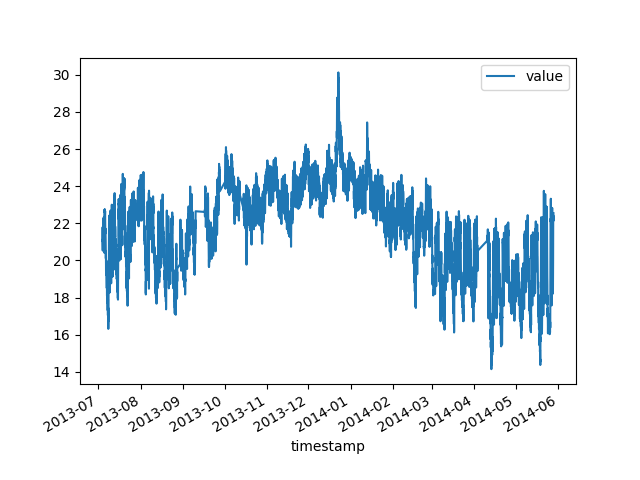

<AxesSubplot:xlabel='timestamp'>

In [10]:
# change fahrenheit to °C 
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value')

## Feature engineering

In [11]:
# the hours and if it's night or day
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [12]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset 
outliers_fraction = 0.01
# We shoul try diff values...

In [13]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

<IPython.core.display.Javascript object>


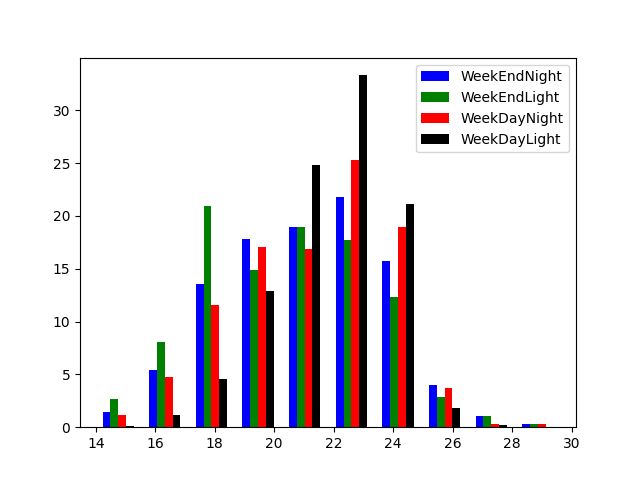

In [14]:
# distinct categories
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [15]:
day_of_the_week = pd.get_dummies(df['DayOfTheWeek'])
day_of_the_week.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

In [16]:
df = df.drop('DayOfTheWeek', axis=1)
frames = [df, day_of_the_week]
df = pd.concat(frames, axis=1)

In [17]:
df

,timestamp,value,hours,daylight,WeekDay,time_epoch,categories,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,2013-07-04 00:00:00,21.044908,0,0,1,13728960,2,0,0,0,1,0,0,0
1,2013-07-04 01:00:00,21.789015,1,0,1,13728996,2,0,0,0,1,0,0,0
2,2013-07-04 02:00:00,21.598781,2,0,1,13729032,2,0,0,0,1,0,0,0
3,2013-07-04 03:00:00,20.533000,3,0,1,13729068,2,0,0,0,1,0,0,0
4,2013-07-04 04:00:00,20.713084,4,0,1,13729104,2,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,1,14012748,3,0,0,1,0,0,0,0
7263,2014-05-28 12:00:00,22.318309,12,1,1,14012784,3,0,0,1,0,0,0,0
7264,2014-05-28 13:00:00,22.248092,13,1,1,14012820,3,0,0,1,0,0,0,0
7265,2014-05-28 14:00:00,22.125126,14,1,1,14012856,3,0,0,1,0,0,0,0



## Cluster only


In [18]:
data = df[['value', 'hours', 'daylight', 'WeekDay', 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
standart_scaler = preprocessing.StandardScaler()
np_scaled = standart_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

pca = PCA(n_components=2)
data = pca.fit_transform(data)

standart_scaler = preprocessing.StandardScaler()
np_scaled = standart_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [19]:
data

,0,1
0,-0.475695,1.736310
1,-0.529805,1.617238
2,-0.521768,1.548759
3,-0.455494,1.527692
4,-0.472089,1.439161
...,...,...
7262,-0.661373,-0.297187
7263,-0.658701,-0.370033
7264,-0.658646,-0.445010
7265,-0.655083,-0.517131


<IPython.core.display.Javascript object>


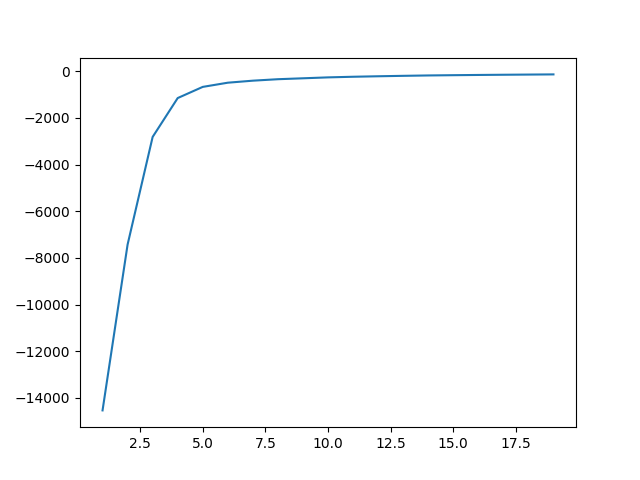

In [20]:
# elbow method
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [21]:
df['cluster'] = kmeans[5].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0    1875
5    1846
1    1522
2     794
4     634
3     596
Name: cluster, dtype: int64

<IPython.core.display.Javascript object>


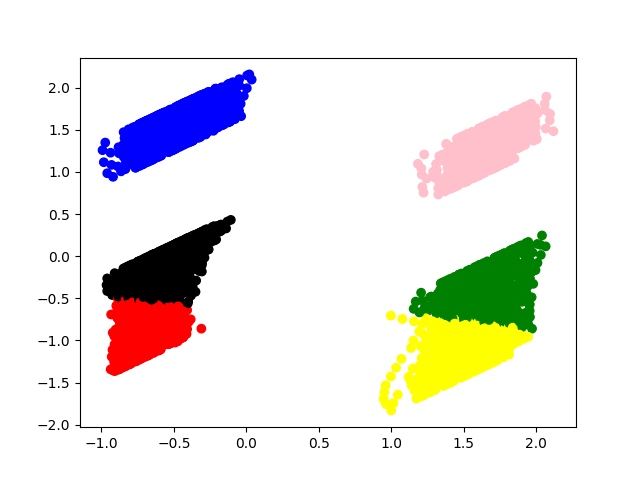

In [22]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'yellow', 5:'black'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [23]:
# creation of 4 differents data set
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

<IPython.core.display.Javascript object>


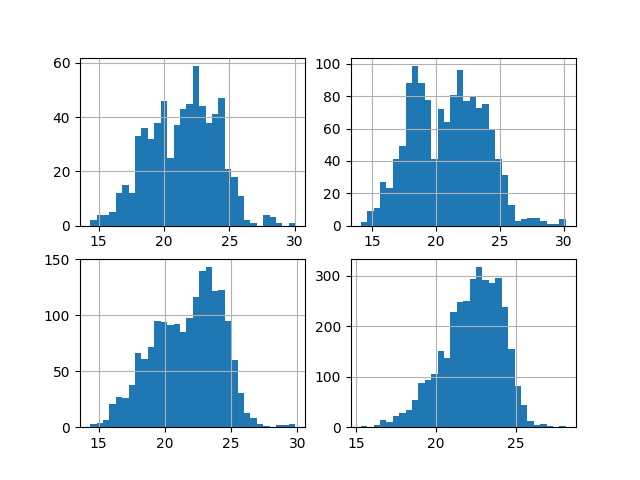

<AxesSubplot:>

In [24]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [25]:
# apply ellipticEnvelope at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

<IPython.core.display.Javascript object>


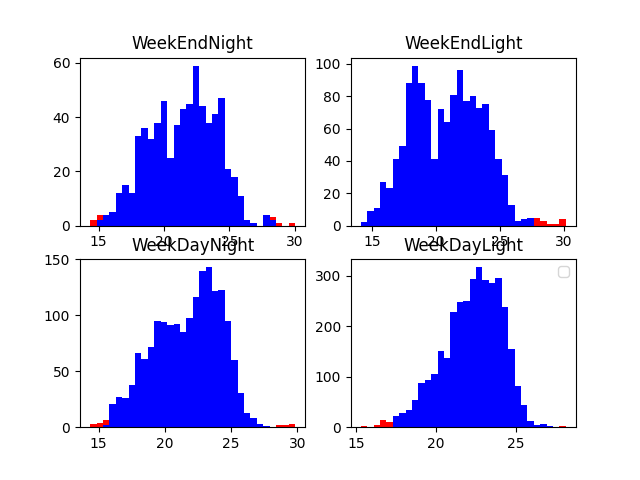

No handles with labels found to put in legend.


In [26]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [27]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 
print(df['anomaly22'].value_counts())

0    7192
1      75
Name: anomaly22, dtype: int64


<IPython.core.display.Javascript object>


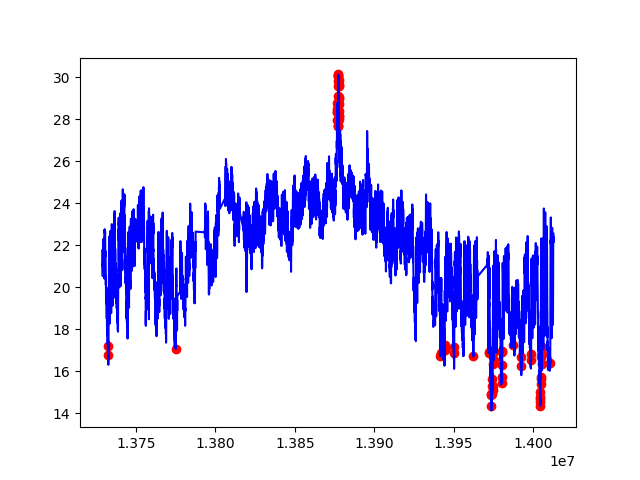

In [28]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>


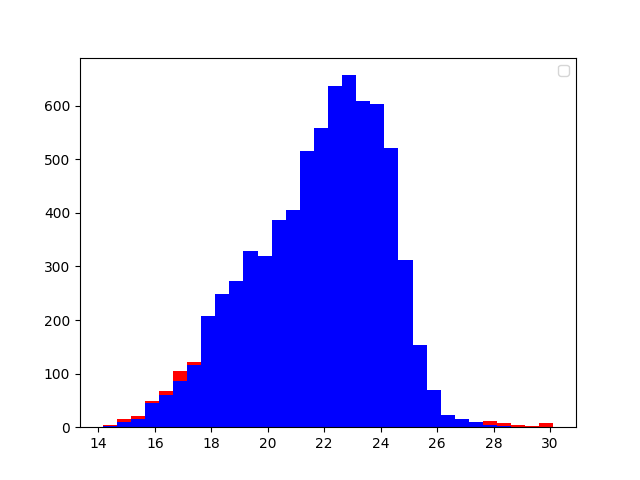

No handles with labels found to put in legend.


In [29]:
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## DBSCAN

In [30]:
dbsc = DBSCAN(eps = 0.065).fit(data)

In [31]:
df['cluster'] = dbsc.labels_
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

 1    3719
 0    1508
 3    1406
 2     580
-1      49
 4       5
Name: cluster, dtype: int64

<IPython.core.display.Javascript object>


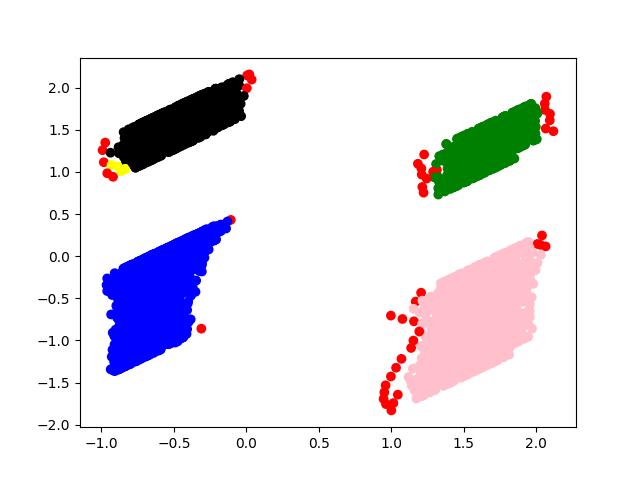

In [32]:
fig, ax = plt.subplots()
colors = {0:'black', 1:'blue', 2:'green', 3:'pink', 4:'yellow', -1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()


## Isolation Forest


In [33]:
data = df[['value', 'hours', 'daylight', 'WeekDay', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
standart_scaler = preprocessing.StandardScaler()
np_scaled = standart_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination = 0.01)
model.fit(data)

df['anomaly_IF'] = pd.Series(model.predict(data))
df['anomaly_IF'] = df['anomaly_IF'].map( {1: 0, -1: 1} )
print(df['anomaly_IF'].value_counts())

0    7194
1      73
Name: anomaly_IF, dtype: int64


<IPython.core.display.Javascript object>


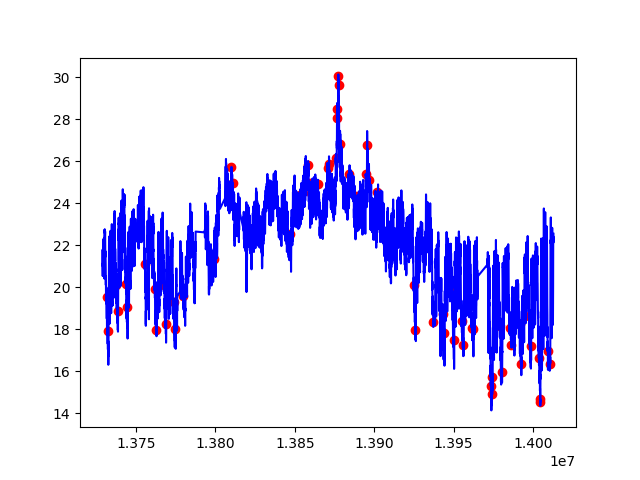

In [34]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly_IF'] == 1, ['time_epoch', 'value']]

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'], a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>


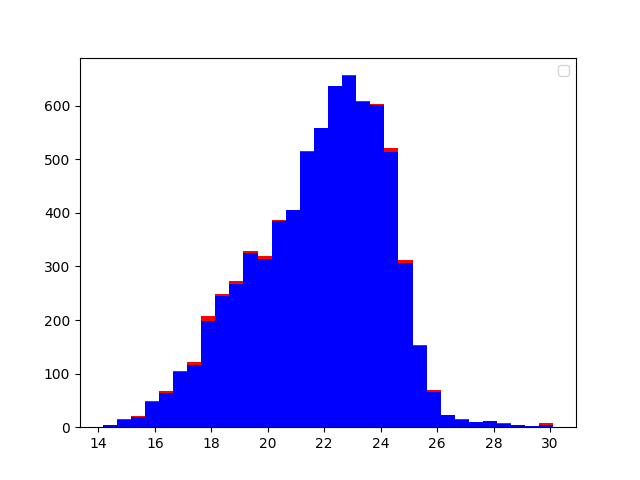

No handles with labels found to put in legend.


In [35]:
a = df.loc[df['anomaly_IF'] == 0, 'value']
b = df.loc[df['anomaly_IF'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## One class SVM

In [36]:
data = df[['value', 'hours', 'daylight', 'WeekDay', 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]
standart_scaler = preprocessing.StandardScaler()
np_scaled = standart_scaler.fit_transform(data)

model =  OneClassSVM(nu=0.95 * outliers_fraction)
data = pd.DataFrame(np_scaled)
model.fit(data)

df['anomaly_svm'] = pd.Series(model.predict(data))
df['anomaly_svm'] = df['anomaly_svm'].map( {1: 0, -1: 1} )
print(df['anomaly_svm'].value_counts())

0    7198
1      69
Name: anomaly_svm, dtype: int64


<IPython.core.display.Javascript object>


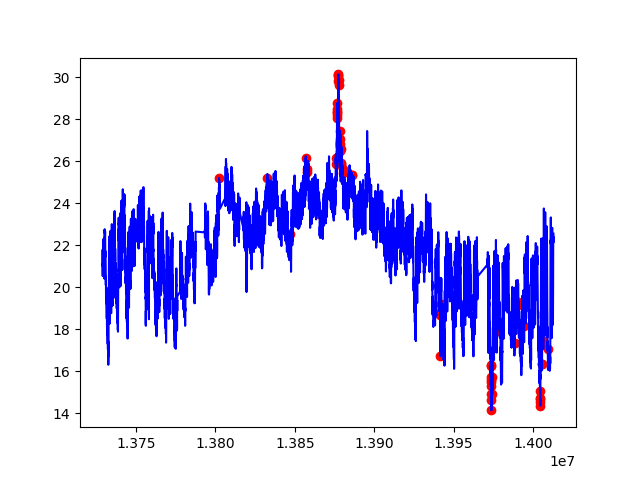

In [37]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly_svm'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'], a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>


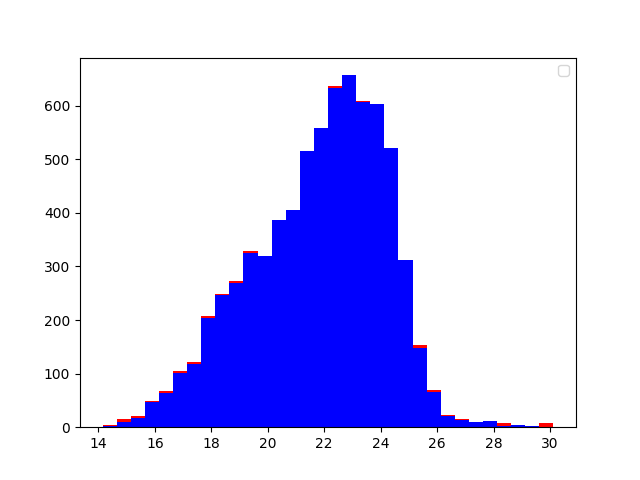

No handles with labels found to put in legend.


In [38]:
a = df.loc[df['anomaly_svm'] == 0, 'value']
b = df.loc[df['anomaly_svm'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## Seasonal Decompose anomaly

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [40]:
df_decom = pd.read_csv("temperature_failure.csv")
df_decom['timestamp'] = pd.to_datetime(df_decom['timestamp'])
df_decom['timestamp'] = df_decom.sort_values('timestamp')
df_decom = df_decom.set_index('timestamp')

In [41]:
result_seasonal = seasonal_decompose(df_decom['value'], model='additive', extrapolate_trend='freq', period = 24)
result_seas = pd.DataFrame({
    'timestamp' : result_seasonal.seasonal.index,
    'trend' : result_seasonal.trend,
    'seasonal' : result_seasonal.seasonal,
    'resid' : result_seasonal.resid
})

result_seas.head()

,timestamp,trend,seasonal,resid
timestamp,,,,
2013-07-04 00:00:00,2013-07-04 00:00:00,69.913104,0.352259,-0.384528
2013-07-04 01:00:00,2013-07-04 01:00:00,69.953947,0.329209,0.937071
2013-07-04 02:00:00,2013-07-04 02:00:00,69.994790,0.162044,0.720970
2013-07-04 03:00:00,2013-07-04 03:00:00,70.035634,0.137535,-1.213768
2013-07-04 04:00:00,2013-07-04 04:00:00,70.076477,-0.001598,-0.791328


In [42]:
# Simple IQR detection
Q1 = np.percentile(result_seas['resid'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(result_seas['resid'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(result_seas['resid'], 75, interpolation = 'midpoint')  
IQR = Q3 - Q1  

low_lim = Q1 - 1.5 * IQR 
up_lim = Q3 + 1.5 * IQR 

In [43]:
result_seas['anomaly'] = ((result_seas['resid'] < low_lim) 
                          | (result_seas['resid'] > up_lim)).astype(int)

In [44]:
result_seas['anomaly'].value_counts()

0    7117
1     150
Name: anomaly, dtype: int64

In [45]:
df_decom['anomaly'] = result_seas['anomaly']

<IPython.core.display.Javascript object>


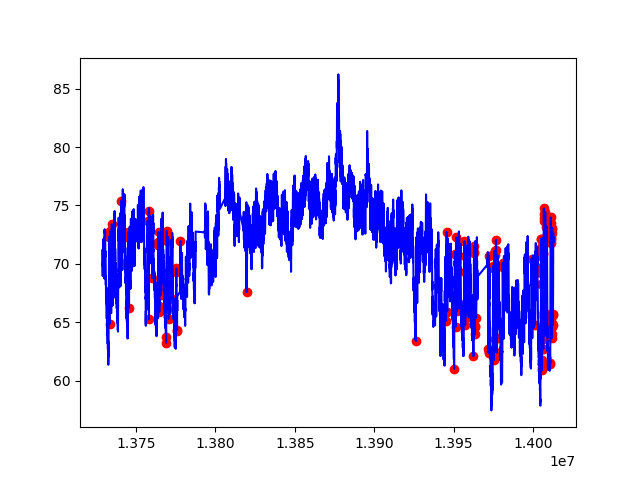

In [46]:
df_decom = df_decom.reset_index()
fig, ax = plt.subplots()

df_decom['time_epoch'] = (df_decom['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

a = df_decom.loc[df_decom['anomaly'] == 1, ['time_epoch', 'value']]

ax.plot(df_decom['time_epoch'], df_decom['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

## Isoforest, One class SVM with seasonal decompose data

In [47]:
df = result_seas.drop('anomaly', axis = 1)
df.tail(10)

,timestamp,trend,seasonal,resid
timestamp,,,,
2014-05-28 06:00:00,2014-05-28 06:00:00,69.555993,-0.536582,-4.235389
2014-05-28 07:00:00,2014-05-28 07:00:00,69.578458,-0.538685,-3.393899
2014-05-28 08:00:00,2014-05-28 08:00:00,69.600923,-0.409742,-1.718613
2014-05-28 09:00:00,2014-05-28 09:00:00,69.623388,-0.389348,-1.200961
2014-05-28 10:00:00,2014-05-28 10:00:00,69.645853,-0.189126,0.998990
2014-05-28 11:00:00,2014-05-28 11:00:00,69.668318,-0.157114,2.859003
2014-05-28 12:00:00,2014-05-28 12:00:00,69.690783,-0.060931,2.543104
2014-05-28 13:00:00,2014-05-28 13:00:00,69.713248,0.074264,2.259053
2014-05-28 14:00:00,2014-05-28 14:00:00,69.735713,0.150859,1.938655


<IPython.core.display.Javascript object>


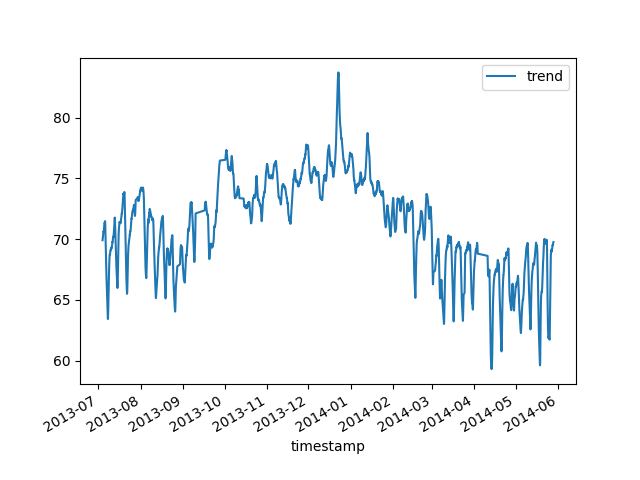

<AxesSubplot:xlabel='timestamp'>

In [48]:
df.plot(x='timestamp', y='trend')

In [49]:
# the hours and if it's night or day
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [50]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset 
outliers_fraction = 0.01
# We shoul try diff values...

In [51]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

<IPython.core.display.Javascript object>


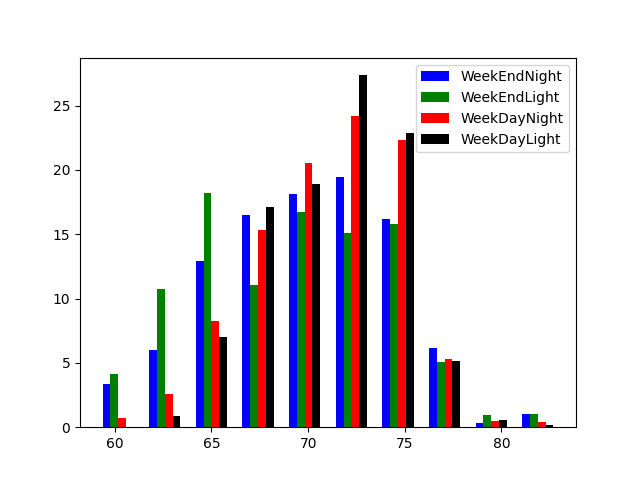

In [52]:
# distinct categories
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'trend']
b = df.loc[df['categories'] == 1, 'trend']
c = df.loc[df['categories'] == 2, 'trend']
d = df.loc[df['categories'] == 3, 'trend']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [53]:
day_of_the_week = pd.get_dummies(df['DayOfTheWeek'])
day_of_the_week.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

In [54]:
df = df.drop('DayOfTheWeek', axis=1)
frames = [df, day_of_the_week]
df = pd.concat(frames, axis=1)

In [55]:
#ISOFOREST
data = df[['trend', 'seasonal', 'resid', 'hours', 'daylight', 'WeekDay', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
standart_scaler = preprocessing.StandardScaler()
np_scaled = standart_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination = 0.01)
model.fit(data)

dt = pd.DataFrame()
dt['anomaly_'] = pd.Series(model.predict(data))
dt['anomaly_'] = dt['anomaly_'].map( {1: 0, -1: 1} )
print(dt['anomaly_'].value_counts())

0    7194
1      73
Name: anomaly_, dtype: int64


In [56]:
#One class SVM
data = df[['trend', 'seasonal', 'resid', 'hours', 'daylight', 'WeekDay', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
standart_scaler = preprocessing.StandardScaler()
np_scaled = standart_scaler.fit_transform(data)

model =  OneClassSVM(nu=0.95 * outliers_fraction)
data = pd.DataFrame(np_scaled)
model.fit(data)

dt['anomaly_svm'] = pd.Series(model.predict(data))
dt['anomaly_svm'] = dt['anomaly_svm'].map( {1: 0, -1: 1} )
print(dt['anomaly_svm'].value_counts())

0    7187
1      80
Name: anomaly_svm, dtype: int64
